In [1]:
#%autoreload

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import yaml
from tqdm import tqdm, trange
import os
import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score, 
    balanced_accuracy_score, 
    confusion_matrix,
    ConfusionMatrixDisplay, 
    accuracy_score,
    classification_report
)
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from torch.utils.tensorboard import SummaryWriter
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import yaml
import os

from sklearn.metrics import (
    f1_score, 
    balanced_accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns 
from lightgbm import LGBMClassifier
pd.set_option('display.max_columns', None)
from torch import nn, Tensor
import copy
from sklearn.preprocessing import StandardScaler

from cnn_utils import (
    PTB_Dataset,
    EarlyStopping,
    set_all_seeds,
    train_and_validate,
    test,
)
#os.getcwd()

In [2]:
#%load_ext autoreload

In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED = 42

TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 256
TEST_BATCH_SIZE = 256


In [4]:
path= "../../data" #r'C:\Users\pauls\Desktop\Studium\Machine Learning for Health Care\Projekt 2\project2_TS_input'
#path = "../../data"
TEST_BATCH_SIZE = 256
SEED = 42

ptb_read_train = pd.read_csv(os.path.join(path, 'ptbdb_train.csv'), header=None)
ptb_read_test = pd.read_csv(os.path.join(path, 'ptbdb_test.csv'), header=None)
X_ptb_train = ptb_read_train.iloc[:, :-1].to_numpy()
X_ptb_test = ptb_read_test.iloc[:, :-1].to_numpy()
y_ptb_train = ptb_read_train.iloc[:, -1].to_numpy()
y_ptb_test = ptb_read_test.iloc[:, -1].to_numpy()

sm = SMOTE(random_state=SEED)
X_ptb_train_resampled, y_ptb_train_resampled = sm.fit_resample(X_ptb_train, y_ptb_train)
print(X_ptb_train_resampled.shape, y_ptb_train_resampled.shape)
print(np.unique(y_ptb_train_resampled, return_counts=True))

# Apply the data loader to the datasets ptb train
ptb_loader_train = DataLoader(
    PTB_Dataset(X_ptb_train_resampled, y_ptb_train_resampled),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
    num_workers=0,
)

# Apply the data loader to the datasets ptb test
ptb_loader_test = DataLoader(
    PTB_Dataset(X_ptb_test, y_ptb_test),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
    num_workers=0,
)

(16808, 187) (16808,)
(array([0., 1.]), array([8404, 8404]))


## Creating the embeddings:

### Embeddings from the CNN encoder (Q1)

In [5]:
class CNN(nn.Module):
    def __init__(self, classes_num: int, in_channels: int):
        super().__init__()

        self.conv1 = self._create_conv_block(in_channels, 32, 3, 1)
        self.conv2 = self._create_conv_block(32, 64, 3, 1)
        self.conv3 = self._create_conv_block(64, 128, 3, 1)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(output_size = 10)

        self.flatten = nn.Flatten(1)
        self.fc = nn.Sequential(
            #nn.Linear(1280, 256),
            nn.Linear(1280, 16),
            nn.Hardswish(),
            nn.Dropout(p=0.2),
            nn.Linear(16, classes_num)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x  

    def _create_conv_block(self, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        return nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=1,
                bias=False
            ),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

class ModifiedCNN(CNN):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.fc[0](x)
        return x

# Replace CNN with the modified version that returns the last conv layer output
model_Q1 = ModifiedCNN(classes_num=5, in_channels=1)

path_Q1 = "../weights/cnn_mitbih.pth"

model_Q1.load_state_dict(torch.load(path_Q1,map_location=DEVICE))
model_Q1.to(DEVICE)

ModifiedCNN(
  (conv1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (adaptive_pool): AdaptiveAvgPool1d(output_size=10)
  (flatten): Flatten(start_dim=1, end_dim=

In [6]:
# Obtain representations
# Initialize an empty list to store the embeddings
embeddings_ptb_train = []

# Ensure the model is in evaluation mode
model_Q1.eval()

# No need to track gradients for this
with torch.no_grad():
    # Iterate over the dataset
    for inputs, _ in ptb_loader_train:
        # Move the inputs to the same device as the model
        inputs = inputs.to(DEVICE)

        # Get the embeddings for this batch and append to the list
        embedding = model_Q1(inputs)
        embeddings_ptb_train.append(embedding.cpu().numpy())

# Convert the list of embeddings to a single numpy array
emb_ptb_train_Q1 = np.concatenate(embeddings_ptb_train, axis=0)

/home/janhsc/miniconda3/envs/ml4hc/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


In [7]:
embeddings_ptb_test = []

# No need to track gradients for this
with torch.no_grad():
    # Iterate over the dataset
    for inputs, _ in ptb_loader_test:
        # Move the inputs to the same device as the model
        inputs = inputs.to(DEVICE)

        # Get the embeddings for this batch and append to the list
        embedding = model_Q1(inputs)
        embeddings_ptb_test.append(embedding.cpu().numpy())

# Convert the list of embeddings to a single numpy array
emb_ptb_test_Q1 = np.concatenate(embeddings_ptb_test, axis=0)

In [8]:
scaler = StandardScaler()
emb_ptb_train_Q1 = scaler.fit_transform(emb_ptb_train_Q1)
emb_ptb_test_Q1 = scaler.transform(emb_ptb_test_Q1)

In [9]:
print(emb_ptb_train_Q1.shape)
print(y_ptb_train_resampled.shape)

(16808, 16)
(16808,)


In [10]:
boost_no_feat_eng_Q1 =LGBMClassifier(
    random_state=42,
    verbose=-1,
    n_jobs=-1,
    n_estimators=1000
)
boost_no_feat_eng_Q1.fit(emb_ptb_train_Q1, y_ptb_train_resampled)

y_preds = boost_no_feat_eng_Q1.predict(emb_ptb_test_Q1)

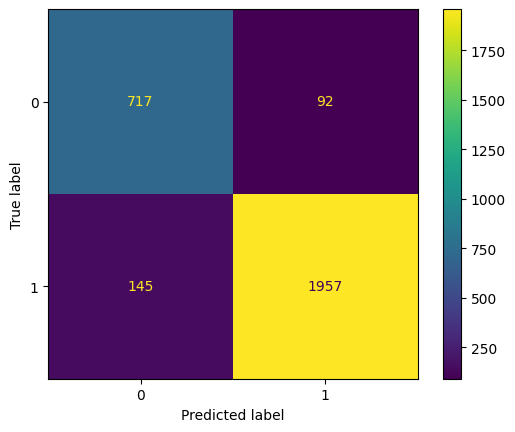

In [11]:
cm = confusion_matrix(y_ptb_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

In [12]:
# calculate precision and recall:
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Test accuracy: {accuracy_score(y_ptb_test, y_preds):.6f}")
print(f"Test balanced accuracy: {balanced_accuracy_score(y_ptb_test, y_preds):.6f}")
print(f"Test f1 score: {f1_score(y_ptb_test, y_preds):.6f}")
print(f"Test precision: {precision:.6f}")
print(f"Test recall: {recall:.6f}")

Test accuracy: 0.918585
Test balanced accuracy: 0.908649
Test f1 score: 0.942905
Test precision: 0.955100
Test recall: 0.931018


In [13]:
print(classification_report(y_ptb_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86       809
         1.0       0.96      0.93      0.94      2102

    accuracy                           0.92      2911
   macro avg       0.89      0.91      0.90      2911
weighted avg       0.92      0.92      0.92      2911



## Embeddings Q2

In [14]:
latent_dim = 16

In [15]:
# We based our CNN on this: https://medium.com/@chen-yu/building-a-customized-residual-cnn-with-pytorch-471810e894ed
class CNNEncoder(nn.Module):
    def __init__(self, latent_dim: int, in_channels: int):
        super().__init__()

        self.conv1 = self._create_conv_block(in_channels, 32, 3, 1)
        self.conv2 = self._create_conv_block(32, 64, 3, 1)
        self.conv3 = self._create_conv_block(64, 128, 3, 1)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(output_size = 10)
        
        
        # Flattening and final linear layer
        self.flatten = nn.Flatten(1)
        self.fc = nn.Linear(1280, latent_dim)

    def forward(self, x: Tensor) -> Tensor:
        x = x.unsqueeze(1) # Add channel dimension
        # now: [batch_size, in_channels, seq_len] i.e. [batch_size, 1, 187]
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.adaptive_pool(x)
        
        x = self.flatten(x)
        x = self.fc(x)
        return x
    
    def _create_conv_block(self, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        return nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=kernel_size, 
                stride=stride, 
                padding=1, 
                bias=False
            ),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )


set_all_seeds(SEED)
encoder=CNNEncoder(latent_dim=latent_dim, in_channels=1).to(DEVICE)

In [16]:
model_Q2 = CNNEncoder(latent_dim=latent_dim, in_channels=1).to(DEVICE)
model_Q2.load_state_dict(torch.load("../weights/encoder_q2.pth", map_location=DEVICE))
model_Q2.to(DEVICE)

CNNEncoder(
  (conv1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (adaptive_pool): AdaptiveAvgPool1d(output_size=10)
  (flatten): Flatten(start_dim=1, end_dim=-

In [17]:
embeddings_ptb_train = []

# Ensure the model is in evaluation mode
model_Q2.eval()

# No need to track gradients for this
with torch.no_grad():
    # Iterate over the dataset
    for inputs, _ in ptb_loader_train:
        # Move the inputs to the same device as the model
        inputs = inputs.to(DEVICE)

        # Get the embeddings for this batch and append to the list
        embedding = model_Q2(inputs)
        embeddings_ptb_train.append(embedding.cpu().numpy())

# Convert the list of embeddings to a single numpy array
emb_ptb_train_Q2 = np.concatenate(embeddings_ptb_train, axis=0)

/home/janhsc/miniconda3/envs/ml4hc/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


In [18]:
embeddings_ptb_test = []

# No need to track gradients for this
with torch.no_grad():
    # Iterate over the dataset
    for inputs, _ in ptb_loader_test:
        # Move the inputs to the same device as the model
        inputs = inputs.to(DEVICE)

        # Get the embeddings for this batch and append to the list
        embedding = model_Q2(inputs)
        embeddings_ptb_test.append(embedding.cpu().numpy())

# Convert the list of embeddings to a single numpy array
emb_ptb_test_Q2 = np.concatenate(embeddings_ptb_test, axis=0)

In [19]:
# np.save("embeddings/emb_ptb_train_Q2", emb_ptb_train_Q2)
# np.save("embeddings/emb_ptb_test_Q2", emb_ptb_test_Q2)

In [20]:
emb_ptb_train_Q2 = scaler.fit_transform(emb_ptb_train_Q2)
emb_ptb_test_Q2 = scaler.transform(emb_ptb_test_Q2)

In [21]:
boost_no_feat_eng_Q2 =LGBMClassifier(
    random_state=42,
    verbose=-1,
    n_jobs=-1,
    n_estimators=1000
)
boost_no_feat_eng_Q2.fit(emb_ptb_train_Q2, y_ptb_train_resampled)

y_preds = boost_no_feat_eng_Q2.predict(emb_ptb_test_Q2)

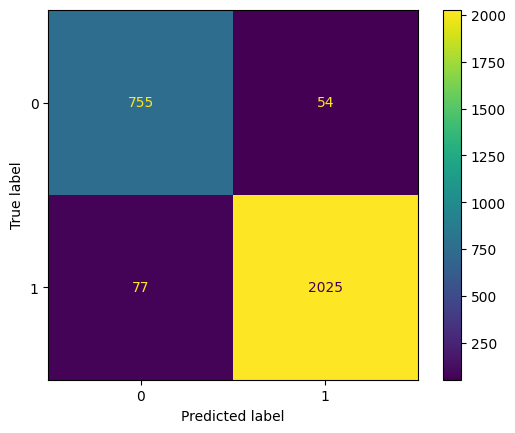

In [22]:
cm = confusion_matrix(y_ptb_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

In [23]:
# calculate precision and recall:
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Test accuracy: {accuracy_score(y_ptb_test, y_preds):.6f}")
print(f"Test balanced accuracy: {balanced_accuracy_score(y_ptb_test, y_preds):.6f}")
print(f"Test f1 score: {f1_score(y_ptb_test, y_preds):.6f}")
print(f"Test precision: {precision:.6f}")
print(f"Test recall: {recall:.6f}")

Test accuracy: 0.954998
Test balanced accuracy: 0.948310
Test f1 score: 0.968668
Test precision: 0.974026
Test recall: 0.963368


In [24]:
print(classification_report(y_ptb_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92       809
         1.0       0.97      0.96      0.97      2102

    accuracy                           0.95      2911
   macro avg       0.94      0.95      0.94      2911
weighted avg       0.96      0.95      0.96      2911



# MLP output layers

For the MLP layers, we'll first have to introduce a training / validation split. Note that we only apply SMOTE on the training set after the train/ validation split has been done.

In [25]:
X_ptb_train, X_ptb_val, y_ptb_train, y_ptb_val = train_test_split(
    X_ptb_train,
    y_ptb_train,
    test_size=0.1, 
    stratify=y_ptb_train, 
    random_state=42
)

sm = SMOTE(random_state=SEED)
X_ptb_train_resampled, y_ptb_train_resampled = sm.fit_resample(X_ptb_train, y_ptb_train)
print(X_ptb_train_resampled.shape, y_ptb_train_resampled.shape)
print(np.unique(y_ptb_train_resampled, return_counts=True))



(15126, 187) (15126,)
(array([0., 1.]), array([7563, 7563]))


It seems like before the Dataloader got the embeddings as the intput. I will have to think about how to go about this.

In [26]:
ptb_train_loader_resampled = DataLoader(
    PTB_Dataset(X_ptb_train_resampled, y_ptb_train_resampled),
    batch_size=32,
    shuffle=True,
    pin_memory=True,
    num_workers=0,
)
ptb_val_loader = DataLoader(
    PTB_Dataset(X_ptb_val, y_ptb_val),
    batch_size=32,
    shuffle=True,
    pin_memory=True,
    num_workers=0,
)
ptb_test_loader = DataLoader(
    PTB_Dataset(X_ptb_test, y_ptb_test),
    batch_size=256,
    shuffle=False,
    pin_memory=True,
    num_workers=0,
)

## Encoder Q1

In [27]:
def freeze_all_but_MLP(model: nn.Module):
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

In [28]:
def unfreeze_encoder(model: nn.Module):
    for param in model.encoder.parameters():
        param.requires_grad = True

### Train the output layer(s) only on the PTB dataset, freezing the encoder.

In [29]:
class Q1_Model(nn.Module):
    def __init__(self, classes_num: int, in_channels: int):
        super().__init__()

        self.encoder = ModifiedCNN(classes_num=5, in_channels=in_channels) # num_classes doesn't matter here; only needed to load encoder correctly
        self.encoder.load_state_dict(torch.load("../weights/cnn_mitbih.pth", map_location=DEVICE))

        self.fc = nn.Sequential(
            nn.Linear(16, 64),
            nn.Hardswish(),
            nn.Dropout(p=0.2),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, classes_num)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.encoder(x)
        x = self.fc(x)
        return x

# Replace CNN with the modified version that returns the last conv layer output
model_Q1_A = Q1_Model(classes_num=2, in_channels=1)

In [30]:
model_Q1_A = model_Q1_A.to(DEVICE)

freeze_all_but_MLP(model_Q1_A)

optimizer = optim.AdamW(model_Q1_A.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", factor=0.5, patience=5, threshold=1e-06, verbose=1
)
early_stopping = EarlyStopping(start=20, patience=20, verbose=1, mode="max")

/home/janhsc/miniconda3/envs/ml4hc/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [31]:
N_EPOCHS=100

model_Q1_A = train_and_validate(
    model = model_Q1_A,
    optimizer = optimizer,
    scheduler = scheduler,
    criterion = criterion,
    train_loader = ptb_train_loader_resampled,
    val_loader = ptb_val_loader,
    best_model_path = "../weights/cnn_Q1_A.pth", #os.path.join(path, "cnn_best_model_MIT_random.pth"),
    device = DEVICE,
    num_epochs = N_EPOCHS,
    ES = early_stopping
)

  0%|          | 0/100 [00:00<?, ?it/s]/home/janhsc/miniconda3/envs/ml4hc/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
/home/janhsc/miniconda3/envs/ml4hc/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
Training CNN:  87%|████████▋ | 87/100 [00:55<00:08,  1.58it/s, train_balanced_acc=0.938, train_loss=0.00473, val_balanced_acc=0.908, val_loss=0.00739]

Early stopping at epoch 87. Best score was 0.9177 in epoch 67.


In [32]:
model_Q1_A.load_state_dict(torch.load("../weights/cnn_Q1_A.pth",map_location=DEVICE))
model_Q1_A.to(DEVICE)

Q1_Model(
  (encoder): ModifiedCNN(
    (conv1): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (adaptive_pool): AdaptiveAvgPool

In [33]:
model_probs, y_preds, y_true, test_loss = test(
    model = model_Q1_A,
    criterion = criterion,
    test_loader = ptb_loader_test,
    device = DEVICE
)

Test loss: 0.0009, Test accuracy: 0.9148, Test balanced accuracy: 0.9152, Test F1 score: 0.9394


### B. Train the entire model on the PTB dataset (encoder + output layers)

In [34]:
# Replace CNN with the modified version that returns the last conv layer output
model_Q1_B = Q1_Model(classes_num=2, in_channels=1)

In [35]:
model_Q1_B = model_Q1_B.to(DEVICE)

optimizer = optim.AdamW(model_Q1_B.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", factor=0.5, patience=5, threshold=1e-06, verbose=1
)
early_stopping = EarlyStopping(start=20, patience=20, verbose=1, mode="max")

/home/janhsc/miniconda3/envs/ml4hc/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [36]:
N_EPOCHS=100

model_Q1_B = train_and_validate(
    model = model_Q1_B,
    optimizer = optimizer,
    scheduler = scheduler,
    criterion = criterion,
    train_loader = ptb_train_loader_resampled,
    val_loader = ptb_val_loader,
    best_model_path = "../weights/cnn_Q1_B.pth", #os.path.join(path, "cnn_best_model_MIT_random.pth"),
    device = DEVICE,
    num_epochs = N_EPOCHS,
    ES = early_stopping
)

  0%|          | 0/100 [00:00<?, ?it/s]/home/janhsc/miniconda3/envs/ml4hc/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training CNN:  64%|██████▍   | 64/100 [01:01<00:34,  1.05it/s, train_balanced_acc=1, train_loss=2.09e-6, val_balanced_acc=0.987, val_loss=0.00349]     

Early stopping at epoch 64. Best score was 0.9901 in epoch 44.


In [37]:
model_Q1_B.load_state_dict(torch.load("../weights/cnn_Q1_B.pth",map_location=DEVICE))
model_Q1_B.to(DEVICE)

Q1_Model(
  (encoder): ModifiedCNN(
    (conv1): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (adaptive_pool): AdaptiveAvgPool

In [38]:
model_probs, y_preds, y_true, test_loss = test(
    model = model_Q1_B,
    criterion = criterion,
    test_loader = ptb_loader_test,
    device = DEVICE
)

Test loss: 0.0006, Test accuracy: 0.9890, Test balanced accuracy: 0.9852, Test F1 score: 0.9924


### C. First, train the output layers, then unfreeze and train the entire joint model in two separate stages.

In [39]:
model_Q1_C = Q1_Model(classes_num=2, in_channels=1)
model_Q1_C = model_Q1_C.to(DEVICE)

We first train the output layers for a low number of epochs for the output layers to adapt to the PTB dataset. Then, we unfreeze the encoder and train the entire model for a higher number of epochs:

In [40]:
freeze_all_but_MLP(model_Q1_C)
optimizer = optim.AdamW(model_Q1_C.parameters(), lr=0.001, weight_decay=0.0001)

In [41]:
model_Q1_C = train_and_validate(
    model = model_Q1_C,
    optimizer = optimizer,
    scheduler = scheduler,
    criterion = criterion,
    train_loader = ptb_train_loader_resampled,
    val_loader = ptb_val_loader,
    best_model_path = "../weights/cnn_Q1_C.pth", #os.path.join(path, "cnn_best_model_MIT_random.pth"),
    device = DEVICE,
    num_epochs = 15,
    ES = None # no early stopping, train for full 10 epochs
)

Training CNN: 100%|██████████| 15/15 [00:09<00:00,  1.62it/s, train_balanced_acc=0.894, train_loss=0.00774, val_balanced_acc=0.892, val_loss=0.00918]


Finally, we train the entire model on the PTB dataset for a higher number of epochs and with a lower learning rate.

In [42]:
unfreeze_encoder(model_Q1_C)

optimizer = optim.AdamW(model_Q1_C.parameters(), lr=0.00005, weight_decay=0.0001)

In [43]:
N_EPOCHS=100

early_stopping = EarlyStopping(start=20, patience=20, verbose=1, mode="max")


model_Q1_C = train_and_validate(
    model = model_Q1_C,
    optimizer = optimizer,
    scheduler = scheduler,
    criterion = criterion,
    train_loader = ptb_train_loader_resampled,
    val_loader = ptb_val_loader,
    best_model_path = "../weights/cnn_Q1_C.pth", #os.path.join(path, "cnn_best_model_MIT_random.pth"),
    device = DEVICE,
    num_epochs = N_EPOCHS,
    ES = early_stopping
)

Training CNN:  88%|████████▊ | 88/100 [01:22<00:11,  1.07it/s, train_balanced_acc=0.994, train_loss=0.000508, val_balanced_acc=0.977, val_loss=0.00292]

Early stopping at epoch 88. Best score was 0.9799 in epoch 68.


In [44]:
model_Q1_C.load_state_dict(torch.load("../weights/cnn_Q1_C.pth",map_location=DEVICE))
model_Q1_C.to(DEVICE)

Q1_Model(
  (encoder): ModifiedCNN(
    (conv1): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (adaptive_pool): AdaptiveAvgPool

In [45]:
model_probs, y_preds, y_true, test_loss = test(
    model = model_Q1_C,
    criterion = criterion,
    test_loader = ptb_loader_test,
    device = DEVICE
)

Test loss: 0.0004, Test accuracy: 0.9794, Test balanced accuracy: 0.9755, Test F1 score: 0.9857


## Encoder Q2

### Train the output layer(s) only on the PTB dataset, freezing the encoder.

We slightly modify the CCNEncoder function from the representation_learning.ipynb file by also adding output layers onto it

In [46]:
class Q2_Model(nn.Module):
    def __init__(self, classes_num: int, in_channels: int):
        super().__init__()

        self.encoder = CNNEncoder(latent_dim=16, in_channels=in_channels).to(DEVICE)
        self.encoder.load_state_dict(torch.load("../weights/encoder_q2.pth", map_location=DEVICE))

        self.fc = nn.Sequential(
            nn.Linear(16, 64),
            nn.Hardswish(),
            nn.Dropout(p=0.2),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, classes_num)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.encoder(x)
        x = self.fc(x)
        return x
#encoder=CNNEncoder(latent_dim=latent_dim, in_channels=1).to(DEVICE)

model_Q2_A = Q2_Model(classes_num=2, in_channels=1)

In [47]:
model_Q2_A = model_Q2_A.to(DEVICE)

optimizer = optim.AdamW(model_Q2_A.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", factor=0.5, patience=5, threshold=1e-06, verbose=1
)
early_stopping = EarlyStopping(start=20, patience=20, verbose=1, mode="max")

/home/janhsc/miniconda3/envs/ml4hc/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [48]:
N_EPOCHS=100

freeze_all_but_MLP(model_Q2_A)

model_Q2_A = train_and_validate(
    model = model_Q2_A,
    optimizer = optimizer,
    scheduler = scheduler,
    criterion = criterion,
    train_loader = ptb_train_loader_resampled,
    val_loader = ptb_val_loader,
    best_model_path = "../weights/cnn_Q2_A.pth", #os.path.join(path, "cnn_best_model_MIT_random.pth"),
    device = DEVICE,
    num_epochs = N_EPOCHS,
    ES = early_stopping
)

Training CNN:  68%|██████▊   | 68/100 [00:43<00:20,  1.55it/s, train_balanced_acc=0.957, train_loss=0.00355, val_balanced_acc=0.95, val_loss=0.00461] 

Early stopping at epoch 68. Best score was 0.9553 in epoch 48.


In [49]:
model_Q2_A.load_state_dict(torch.load("../weights/cnn_Q2_A.pth",map_location=DEVICE))
model_Q2_A.to(DEVICE)

Q2_Model(
  (encoder): CNNEncoder(
    (conv1): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (adaptive_pool): AdaptiveAvgPool1

In [50]:
model_probs, y_preds, y_true, test_loss = test(
    model = model_Q2_A,
    criterion = criterion,
    test_loader = ptb_loader_test,
    device = DEVICE
)

Test loss: 0.0005, Test accuracy: 0.9581, Test balanced accuracy: 0.9573, Test F1 score: 0.9706


### B. Train the entire model on the PTB dataset (encoder + output layers)

In [51]:
model_Q2_B = Q2_Model(classes_num=2, in_channels=1)
model_Q2_B = model_Q2_B.to(DEVICE)

optimizer = optim.AdamW(model_Q2_B.parameters(), lr=0.001, weight_decay=0.0001)
early_stopping = EarlyStopping(start=20, patience=20, verbose=1, mode="max")

In [52]:
N_EPOCHS=100

model_Q2_B = train_and_validate(
    model = model_Q2_B,
    optimizer = optimizer,
    scheduler = scheduler,
    criterion = criterion,
    train_loader = ptb_train_loader_resampled,
    val_loader = ptb_val_loader,
    best_model_path = "../weights/cnn_Q2_B.pth", #os.path.join(path, "cnn_best_model_MIT_random.pth"),
    device = DEVICE,
    num_epochs = N_EPOCHS,
    ES = early_stopping
)

Training CNN:  46%|████▌     | 46/100 [00:42<00:49,  1.08it/s, train_balanced_acc=0.998, train_loss=0.000192, val_balanced_acc=0.978, val_loss=0.00256] 

Early stopping at epoch 46. Best score was 0.9936 in epoch 26.


In [53]:
model_Q2_B.load_state_dict(torch.load("../weights/cnn_Q2_B.pth",map_location=DEVICE))
model_Q2_B.to(DEVICE)

Q2_Model(
  (encoder): CNNEncoder(
    (conv1): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (adaptive_pool): AdaptiveAvgPool1

In [54]:
model_probs, y_preds, y_true, test_loss = test(
    model = model_Q2_B,
    criterion = criterion,
    test_loader = ptb_loader_test,
    device = DEVICE
)

Test loss: 0.0004, Test accuracy: 0.9959, Test balanced accuracy: 0.9941, Test F1 score: 0.9971


### C. First, train the output layers, then unfreeze and train the entire joint model in two separate stages.

In [55]:
model_Q2_C = Q2_Model(classes_num=2, in_channels=1)

Again, we first train the output layers for a low number of epochs for the output layers to adapt to the PTB dataset. Then, we unfreeze the encoder and train the entire model for a higher number of epochs:

In [56]:
model_Q2_C = model_Q2_C.to(DEVICE)
freeze_all_but_MLP(model_Q2_C)
optimizer = optim.AdamW(model_Q2_C.parameters(), lr=0.001, weight_decay=0.0001)

In [57]:
model_Q2_C = train_and_validate(
    model = model_Q2_C,
    optimizer = optimizer,
    scheduler = scheduler,
    criterion = criterion,
    train_loader = ptb_train_loader_resampled,
    val_loader = ptb_val_loader,
    best_model_path = "../weights/cnn_Q1_C.pth", #os.path.join(path, "cnn_best_model_MIT_random.pth"),
    device = DEVICE,
    num_epochs = 15,
    ES = None # no early stopping, train for full 10 epochs
)

Training CNN: 100%|██████████| 15/15 [00:09<00:00,  1.63it/s, train_balanced_acc=0.926, train_loss=0.0058, val_balanced_acc=0.941, val_loss=0.00537] 


Finally, we train the entire model on the PTB dataset for a higher number of epochs and with a lower learning rate.

In [58]:

early_stopping = EarlyStopping(start=20, patience=20, verbose=1, mode="max")
#Note: We lowered the learning rate here
optimizer = optim.AdamW(model_Q2_C.parameters(), lr=0.00005, weight_decay=0.0001)

In [59]:
N_EPOCHS=100

unfreeze_encoder(model_Q2_C)

model_Q2_C = train_and_validate(
    model = model_Q2_C,
    optimizer = optimizer,
    scheduler = scheduler,
    criterion = criterion,
    train_loader = ptb_train_loader_resampled,
    val_loader = ptb_val_loader,
    best_model_path = "../weights/cnn_Q2_C.pth", #os.path.join(path, "cnn_best_model_MIT_random.pth"),
    device = DEVICE,
    num_epochs = N_EPOCHS,
    ES = early_stopping
)

Training CNN:  69%|██████▉   | 69/100 [01:04<00:28,  1.08it/s, train_balanced_acc=0.998, train_loss=0.000229, val_balanced_acc=0.989, val_loss=0.00146]

Early stopping at epoch 69. Best score was 0.9911 in epoch 49.


In [60]:
model_Q2_C.load_state_dict(torch.load("../weights/cnn_Q2_C.pth",map_location=DEVICE))
model_Q2_C.to(DEVICE)

Q2_Model(
  (encoder): CNNEncoder(
    (conv1): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (adaptive_pool): AdaptiveAvgPool1

In [61]:
model_probs, y_preds, y_true, test_loss = test(
    model = model_Q2_C,
    criterion = criterion,
    test_loader = ptb_loader_test,
    device = DEVICE
)

Test loss: 0.0002, Test accuracy: 0.9924, Test balanced accuracy: 0.9898, Test F1 score: 0.9948
